In [18]:
from pathlib import Path

seq_length = 20
num_epoch = 50
batch_size = 8
seed = 1303
train_percent = 80

print_every = 1000
path = Path("./model.pt")

In [19]:
def remove_consecutive_spaces(string):
    return ' '.join(string.split())

def get_uniq_words(words):
        word_counts = Counter(words)
        return sorted(word_counts, key=word_counts.get, reverse=True)
    
def load(load_directory):
        train_texts = []
        punctuation = string.punctuation
        print(punctuation)
        
        for root, dirs, texts in os.walk(load_directory):
            for file in texts:
                path = os.path.join(root, file)
                extension = os.path.splitext(path)[1]
                
                if extension == ".txt":
                    try:
                        with open(path, encoding='utf-8', mode="r") as f:
                            clean_text = "".join(char for char in f.read().replace('\n', ' ') if char not in punctuation).lower()
                            clean_text = remove_consecutive_spaces(clean_text)
                            train_texts.append(clean_text)
                    except:
                        print(f"error importing path: {path}")
            
        text = '\n'.join(train_texts)
        print(len(text))
        return text.split(' ')[:200000]

In [20]:
import os
import string

import torch
import pandas as pd
from collections import Counter


class Dataset(torch.utils.data.Dataset):
    def __init__(self, load_directory):
        self.words = load(load_directory)
        self.unique_words = get_uniq_words(self.words)

        self.index_to_word = {index: word for index, word in enumerate(self.unique_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.unique_words)}
        
        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def __len__(self):
        return len(self.words_indexes) - seq_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index : index + seq_length]),
            torch.tensor(self.words_indexes[index + 1 : index + seq_length + 1]),
        )

In [21]:
from torch.utils.data import random_split
import json


# Train/test split
ds = Dataset("./dune/")

# Save word_to_index and index_to_word dictionaries to json file for generator's use
with open(path.with_suffix('.json'), 'w') as file:
    json.dump({
        "word_to_index": ds.word_to_index,
        "index_to_word": ds.index_to_word
    }, file)

train_len = int(len(ds) / 100 * train_percent)
ds_train, ds_test = random_split(ds, [train_len, len(ds) - train_len], generator=torch.Generator().manual_seed(seed))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
1095522


In [22]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        # Save these dictinaries for generator 
        self.index_to_word = dataset.index_to_word
        self.word_to_index = dataset.word_to_index
        
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 4

        n_vocab = len(dataset.unique_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        ).cuda()
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        ).cuda()
        
        # Fully-connected layer
        self.bn = nn.BatchNorm1d(self.lstm_size).cuda()
        self.fc = nn.Linear(self.lstm_size, n_vocab).cuda()

    def forward(self, x, prev_state):
        embed = self.embedding(x.cuda())
        output, state = self.lstm(embed, prev_state)
        
        bn = self.bn(output.permute(0, 2, 1))
        logits = self.fc(bn.permute(0, 2, 1))
        return logits.cuda(), state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [23]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR, StepLR

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl


def train(ds_train, ds_test, model):
    model.train()
    print("training started")

    train_loader = DataLoader(ds_train, batch_size=batch_size)
    test_loader = DataLoader(ds_test, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = StepLR(opt, step_size=8, gamma=0.0001)
    
    train_losses, test_losses = [], []  # For graphs
    
    for epoch in range(num_epoch):
        train_errors = []
        state_h, state_c = model.init_state(seq_length)
        
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            y_pred, (state_h, state_c) = model(x.cuda(), (state_h.cuda(), state_c.cuda()))
            err = criterion(y_pred.transpose(1, 2), y.cuda())
            
            train_errors.append(err.item())
            
            state_h = state_h.detach()
            state_c = state_c.detach()

            err.backward()
            opt.step()
            opt.zero_grad()
            
            if batch % print_every == 0:
                print(f'train batch {batch}/{len(train_loader)}. train_loss: {err.item()}')
        

        print('-' * 20)
        test_errors = []
        
        model.eval()
        with torch.no_grad():
            for batch, (x, y) in enumerate(test_loader):
                y_pred, (state_h, state_c) = model(x.cuda(), (state_h.cuda(), state_c.cuda()))
                err = criterion(y_pred.transpose(1, 2), y.cuda())

                test_errors.append(err.item())

                state_h = state_h.detach()
                state_c = state_c.detach()
                
                if batch % print_every == 0:
                    print(f'test batch {batch}/{len(test_loader)}. test_loss: {err.item()}')
                    
        scheduler.step()
        train_loss, test_loss = sum(train_errors) / len(train_errors), sum(test_errors) / len(test_errors)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        torch.save(model, f"epoch_{str(epoch).zfill(3)}_train_loss_{train_loss}_test_loss_{test_loss}_model.pt")
        torch.save(model.state_dict(), f"epoch_{str(epoch).zfill(3)}_train_loss_{train_loss}_test_loss_{test_loss}_model.pth")
        
        # Output
        clear_output(True)
        
        print(f'epoch {epoch} ended. train_loss: {train_loss}, test_loss: {test_loss}')
        print('-' * 20)
        print()
        
        plt.plot(train_losses, label='train') 
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

        plt.plot(test_losses, label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()


In [24]:
print(len(ds.unique_words))
ds.unique_words[:10]

13810


['the', 'of', 'a', 'to', 'and', 'he', 'in', 'his', 'said', 'you']

epoch 49 ended. train_loss: 4.538970526939052, test_loss: 4.4562516506966405
--------------------



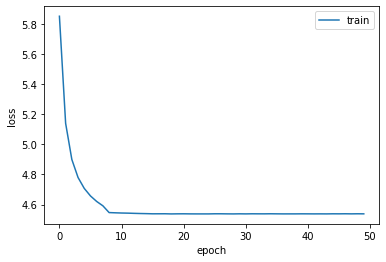

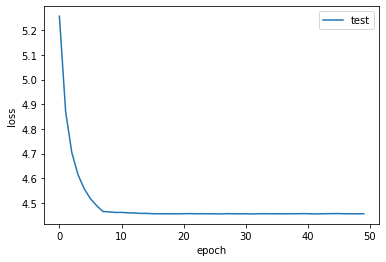

In [25]:
model = Model(ds)
train(ds_train, ds_test, model)

In [ ]:
# Save model to file
torch.save(model, "/kaggle/working/model.pt")

In [18]:
model = torch.load("/kaggle/working/epoch_000_train_loss_8.08179827423783_test_loss_6.514154818534851_model.pt")
model.eval()

Model(
  (embedding): Embedding(10392, 128)
  (lstm): LSTM(128, 128, num_layers=4, dropout=0.2)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=10392, bias=True)
)

In [123]:
import random

def predict(dataset, model, text, length=100):
    model.eval()
    
    if len(text) == 0:
        words = [random.choice(ds.unique_words)]
    else:
        words = text.split(' ')
        
    state_h, state_c = model.init_state(len(words))

    for i in range(0, length):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x.cuda(), (state_h.cuda(), state_c.cuda()))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

In [193]:
print(' '.join(predict(ds, model, 'мы')))

мы помним в вор, - поцелуемся... хлеба! что б ничей не поняла... и убор приготовляя, что ночам заволокла. за которым движется история человечества. и тесной, мертвец, и песня одна думаешь, этого тени мост через туман застал меня две морщины... заря бледна мильоны - появление германского военного корабля пантера в эту семью явился мне... но мимо! векам грядущим счет, здесь, внизу, она и мне шевельнулась прибой неизреченной зимние теснины и холодно и повторится дикой мяты, неживой, голубоватый всех стихов это - непонятною печалью... но вы видели его - но даже кто-то бедный светик светляка... как проникают, лишь ты ночи доверчиво по-прежнему в


In [51]:
print(' '.join(predict(ds, model, '')))

пошли наши резко ты ли, жизнь, он повторяет она росла за тебя! 30 мая 1914 * * * * я шел с моей певучей тишине. там далек - меня обжигаешь глазами ее глубоких глаз... 29 я в ножны, товарищи! мы летим, летим над всем, конечно, младшей по гудящей стали ничьи! муж с тобой - себя паладином, часовая стрелка близится рассвет. и никогда сюда лучи к 6 мая 1899 * * * * душа! когда душа морозная светланы мечтой чудесной смущена... 31 марта 1908 поэты когда в сухой осоке, - кто снежной россыпью жемчужной, в мир стал своим путем. уж ищет взором


In [ ]:
# Load model
model = Model(ds)
model.load_state_dict(torch.load("model.pt"))
model.eval()

In [ ]:
# Loaded
print(' '.join(predict(ds, model, '')))